# Exploring Fourier Tools and Their Practical Applications
Created By: Autumn Stephens <br>
Creation Date: 2/25/2023 <br>
Last Edited: 3/17/2023

Fourier series and transforms are vital tools in many industries today, but most students will never learn about them. Even those who have learned about these tools may not understand what they do or how they are helpful. In this notebook, we will build an intuition for what both tools do without performing complicated calculations.


__NOTE:__ To improve readability, several functions I wrote for this demo have been transferred to a separate module. If you want to see how these functions work, please look through the "fourier_tools_custom.py" file.

In [1]:
### Necessary Imports
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import cv2
import io
from scipy import signal
from scipy.io import wavfile
from IPython.display import Audio
from ipywidgets import interactive
from tqdm import tqdm

### Custom library where functions are defined
import fourier_tools_custom as ftc

## How do waves work?
The simplest wave we see in physics comes from our basic trig functions (i.e., sin(x) and cos(x)). In general, the equation of these basic waves is given by

\begin{equation}
y = A \sin(\omega x + \phi)
\end{equation}


where $A$ is the amplitude, $\omega$ is the frequency, and $\phi$ is the phase shift. Sometimes, two waves interact either __constructively__ (their amplitudes add to a greater value) or __destructively__ (their amplitudes cancel out). Remember these concepts because they are important to how Fourier series and transforms work! The following code block allows you to explore how amplitude, frequency, and phase shift changes create different interference patterns.

In [2]:
### Create the interactive plot with sliders for amplitude, frequency, and phase shift
interactive_plot = interactive(ftc.plot_waveform, 
                               amplitude=(0, 1, 0.1),
                               frequency=(0.1, 2*np.pi, 0.1),
                               phase_shift=(0, 2*np.pi, 0.1))

### Show the interactive plot
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=0.5, description='amplitude', max=1.0), FloatSlider(value=3.1415926535…

You may see now that adding different waves together can produce unique shapes, which is the basis for the Fourier series. When you add waves of different amplitudes, frequencies, and phase shifts together, you can get closer to replicating the shape of other functions. This may not convince you, but in the next code block, we will demonstrate this technique in action!

In [3]:
# Create the interactive plot with sliders for amplitude, frequency, and phase shift
interactive_plot = interactive(ftc.plot_fourier,
                               sawtooth_period=(1, 2, 0.1),
                               N=(0, 30, 1))

# Show the interactive plot
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='sawtooth_period', max=2.0, min=1.0), IntSlider(value…

You should now be convinced that by adding in many different sine waves, you can reproduce nearly any shape or function! In STEM fields, this process is particularly useful in representing step functions with a smooth, continuous equations.

## What is a Fourier Transform?
The Fourier transform allows for the analysis of any input wave data. If that data is continuous, you must calculate the transform using an integral method. In our computations, we will be working with discrete data, so we will instead use Fast-Fourier Transforms (FFTs). These both serve the same primary function, so an understanding of FFTs will also transfer to regular Fourier transforms.


### _Single Note Example_
We will start by exploring how Fourier Transforms relate to audio and then use that to explore other uses. Audio travels in waves, meaning that by altering the frequency of a waveform, we can adjust the pitch we hear. Listen to the following audio that plays a middle C using a simple sine wave:

In [4]:
# Define the duration of the note in seconds
duration = 3

# Define the frequency of the middle C note in Hz
freq = 261.63

# Generate a sine wave for the middle C note
samples = (np.sin(2*np.pi*np.arange(44100*duration)*freq/44100))
Audio(samples, rate=44100)

The Fourier transform of this audio is shown below, we would see the following:

(0.0, 523.26)

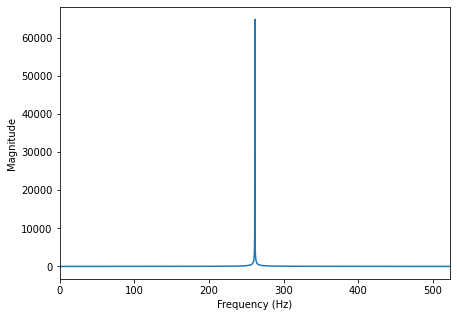

In [5]:
# Compute the FFT of the signal
fft = np.fft.fft(samples)

# Compute the frequency axis for the FFT
freqs = np.fft.fftfreq(len(samples), 1/44100)

# Plot the magnitude spectrum of the signal
plt.plot(freqs[:len(samples)//2], np.abs(fft)[:len(samples)//2])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, freq*2)

There is a clear peak at a frequency of 261.63 Hz (middle C). You can think of the FFT as a function that picks out the frequencies in a signal. Since there is only one frequency in our signal, we get a sharp peak at that value. This may be hard to understand, so let us take a look at a more complicated example to solidify your intuition.

### _FFT of a Chord_
Instead of just considering a single note (middle C), we will now play a C major chord. The chord we play below is made up of four notes: C4, E4, G4, and C5. We can generate the waveform for each note individually, but that will not produce the chord sound we want. Instead, we will need to add all these waveforms together to produce a single sound.

In [6]:
# Define the duration of the note in seconds
duration = 5

# Define the frequency of notes in Hz
freq_list = [261.63, 329.63, 392.00, 523.25]

# Generate a sine wave for each note
samples_list = [(np.sin(2*np.pi*np.arange(44100*duration)*freq/44100)) for freq in freq_list]
final_audio = sum(samples_list)

Audio(final_audio, rate=44100)

And the corresponding FFT is given by:

(0.0, 800.0)

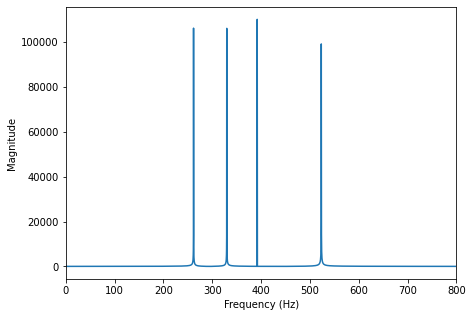

In [7]:
# Compute the FFT of the signal
fft = np.fft.fft(final_audio)

# Compute the frequency axis for the FFT
freqs = np.fft.fftfreq(len(final_audio), 1/44100)

# Plot the magnitude spectrum of the signal
plt.plot(freqs[:len(final_audio)//2], np.abs(fft)[:len(final_audio)//2])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 800)

We see there are four sharp peaks, each at a frequency corresponding to the notes in our C major chord, just like we expected! In fact, all audio is made up of some principal frequencies that make it unique from all other audio. But, what happens when we have audio that is much more complex than a simple sine wave?

### _Analyzing Instruments_

If you listen to an orchestra, you likely have no problem distinguishing a trumpet from a flute. Even if they were playing the same notes, you would recognize that the flute sounded airier than the trumpet. To understand why, we will repeat the above process for a piano, trumpet, violin, and flute all playing the same note:

In [8]:
max_time = 1
instruments = ["flute", "piano", "trumpet", "violin"]

for instrument in instruments:
    filename = "instrument_files/" + instrument + "-C5.wav"

    ### Read the WAV file from the io.BytesIO object
    sampling_rate, audio = wavfile.read(filename)
    
    print("Audio of " + instrument)
    display(Audio(audio, rate=sampling_rate))

Audio of flute


Audio of piano


Audio of trumpet


Audio of violin


You should be able to distinctly identify each instrument. If you listen closely, you can also hear how the audio is not flat (the frequency changes over time). This is what creates the unique sound for each instrument. We can see this difference expressed in the FFT as shown below:

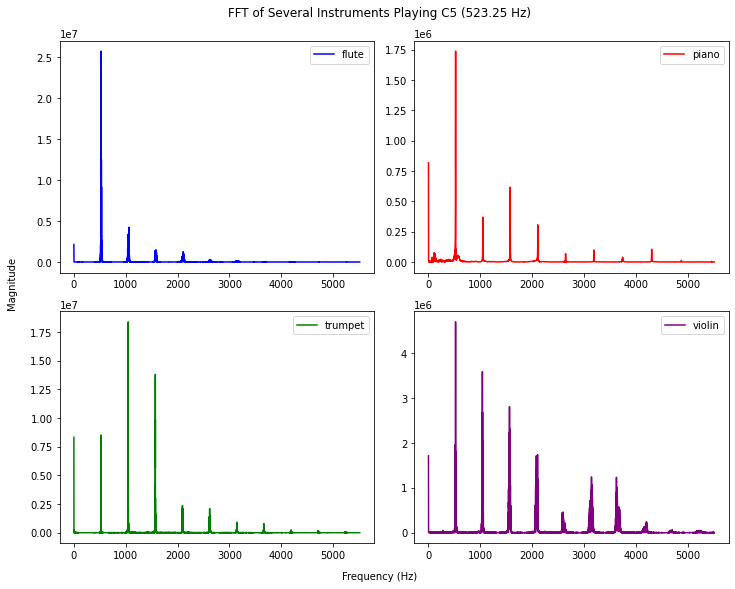

In [9]:
### Defines instrument / color combinations for plotting
instruments = ["flute", "piano", "trumpet", "violin"]
colors = ['blue', 'red', 'green', 'purple']

### Creates a 2x2 figure with subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

### Iterates over each subplot and instrument
for instrument, color, ax in zip(instruments, colors, axs.flat):
    
    ### Read the WAV file
    filename = "instrument_files/" + instrument + "-C5.wav"
    sampling_rate, audio = wavfile.read(filename)
    
    ### Compute the FFT of the signal
    fft = np.fft.fft(audio)

    ### Compute the frequency axis for the FFT
    freqs = np.fft.fftfreq(len(audio), 1/sampling_rate)

    ### Plot the magnitude spectrum of the signal
    ax.plot(freqs[:len(audio)//2], np.abs(fft)[:len(audio)//2], label=instrument, color=color)
    ax.legend()
    
fig.suptitle("FFT of Several Instruments Playing C5 (523.25 Hz)")
fig.text(0.5, -0.01, 'Frequency (Hz)', ha='center', va='center')
fig.text(-0.01, 0.5, 'Magnitude', ha='center', va='center', rotation='vertical')
fig.tight_layout()

We see that while some of these FFTs share similar peak frequencies, their magnitude and shape vary between instruments. These differences are what create unique sounds between instruments. One of the most interesting parts about FFTs, though, is when you alter them.

## Applications of Fourier Transforms
Below, we explore how Fourier transforms are used in the real world. The examples included are not exhaustive, so I encourage you to seek out other ways to use FFTs!

### _Audio Compression_
As you can imagine, the amount of data it takes to store complex waveforms are relatively large. Consider large music streaming applications like Spotify or Apple Music. If there was a way to simplify the waveforms of songs while still retaining a similar sound quality, audio storage requirements would drop drastically.

Imagine taking the FFT of an audio source and then reconstructing that audio by adding in waves with frequencies given by the FFT. Frequencies with a high magnitude most impact the similarity. To prove this point, interact with the "virtual jukebox" below. It reconstructs a source audio by adding these peak frequencies in orders of magnitude. All audio resources are pulled from [this](https://www2.cs.uic.edu/~i101/SoundFiles/) website, so the .wav files will not be available if it goes down. Please reference the following table to find which entry number to use in the function call:


| Entry # | Filename |
|---|---|
| 0 | BabyElephantWalk60.wav |
| 1 | CantinaBand3.wav |
| 2 | CantinaBand60.wav |
| 3 | Fanfare60.wav |
| 4 | gettysburg10.wav |
| 5 | gettysburg.wav |
| 6 | ImperialMarch60.wav |
| 7 | PinkPanther30.wav |
| 8 | PinkPanther60.wav |
| 9 | preamble10.wav |
| 10 | preamble.wav |
| 11 | StarWars3.wav |
| 12 | StarWars60.wav |
| 13 | taunt.wav |

100%|██████████| 7/7 [00:00<00:00, 11.71it/s]


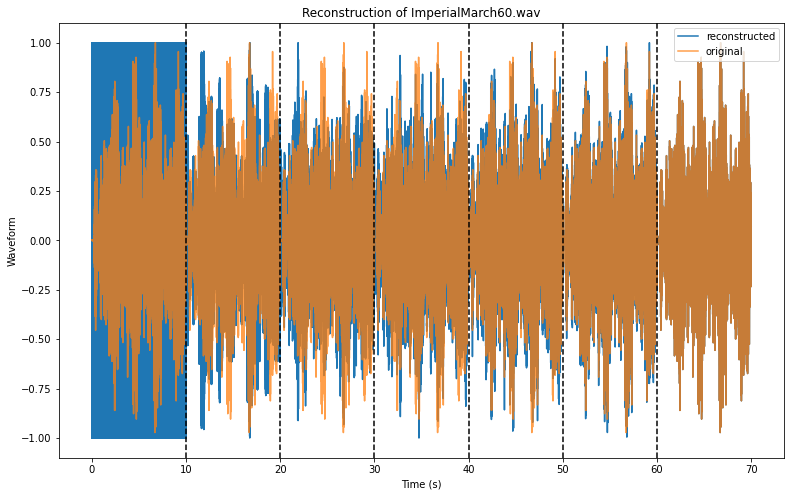

In [10]:
ftc.jukebox_player(entry_number=6, max_clip_length=10)

Each segment is recreated using the frequencies corresponding to the top N magnitudes in the source audio's FFT. Each segment's N-value increases by a factor of 10 until reaching every term in the last segment. While we see that the initial reconstructed audio is very wrong, it converges to a similar waveform before all the terms are added. You should also be able to hear this trend! The original audio starts poking into the foreground as you add more terms. What does this mean?

We can replicate audio to a level nearly indistinguishable from the original without the entire FFT. Hence, we can cut off the lower-magnitude terms to conserve data. This is one of the many uses of FFTs in modern industries.

If you want to apply the same process to your .wav file, specify its file location in the format below. Note that the function does not work if the .wav file has any metadata representing non-audio information (i.e., artist's name, band, etc.).

In [11]:
#ftc.jukebox_player(file_source='path/to/example.wav', max_clip_length=10)

### _Photo Editing / Manipulation_
Fourier transforms can be applied to more than sound waves. Below, we explore how FFTs can be performed on 2D images and how this allows for useful image manipulation. Consider the 2D FFT of the following reference image:

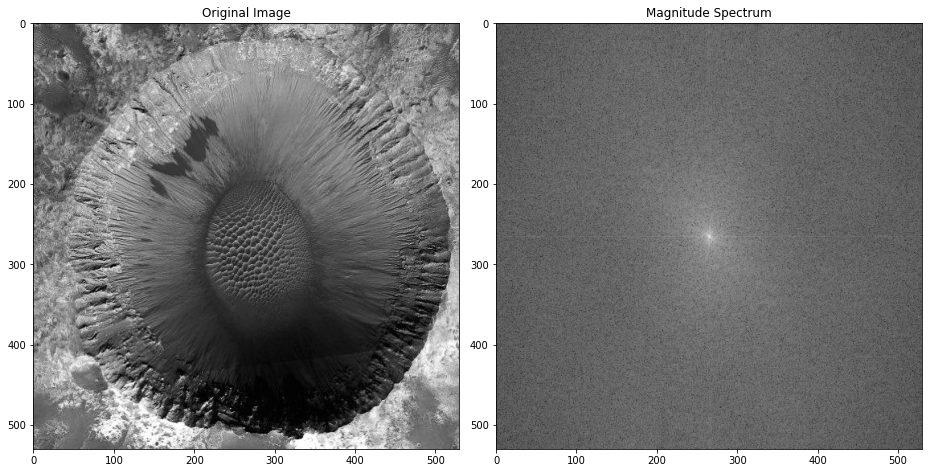

In [12]:
### Load the image from a URL in grayscale
url = 'https://pbs.twimg.com/media/Eb7ZCe4XkAEJPTz?format=jpg&name=small'
resp = urllib.request.urlopen(url)
img = np.asarray(bytearray(resp.read()), dtype="uint8")
img = cv2.imdecode(img, cv2.IMREAD_GRAYSCALE)

### Calculate the 2D Fourier transform
f = np.fft.fft2(img)

### Shift the zero-frequency component to the center of the spectrum
fshift = np.fft.fftshift(f)

### Calculate the magnitude spectrum
magnitude_spectrum = 20*np.log(np.abs(fshift))

### Plots image and FFT data
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(img, cmap='gray')
ax[0].set_title("Original Image")
ax[1].imshow(magnitude_spectrum, cmap='gray')
ax[1].set_title('Magnitude Spectrum')
fig.tight_layout()

Recall that FFTs are a method for isolating the frequencies that make up an input signal. Similarly, in 2D images, the magnitude spectrum maps out the prevalence of frequencies that make up an image. It may help to imagine that higher frequencies correspond with a sharper change, and lower frequencies correspond with slower ones. Hence, anywhere where a sudden change in color occurs in our source image shows up as a high-frequency signal in our 2D FFT. See what happens when we slowly block out all signals from this middle region and convert the FFT back into an image:

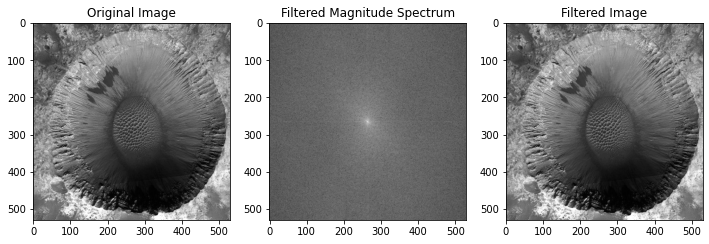

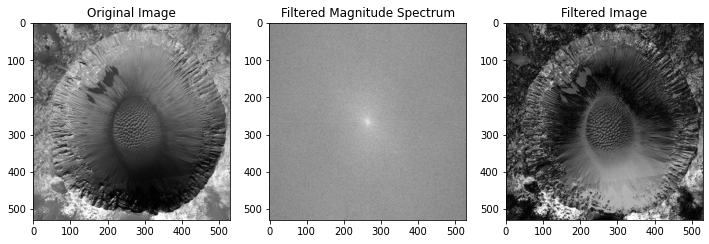

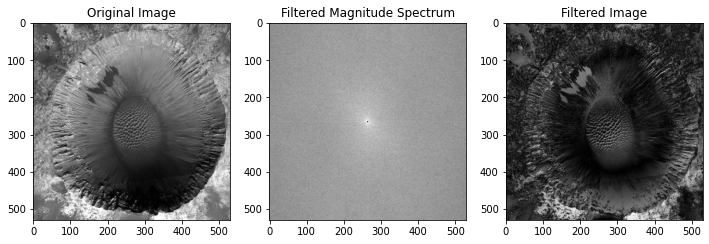

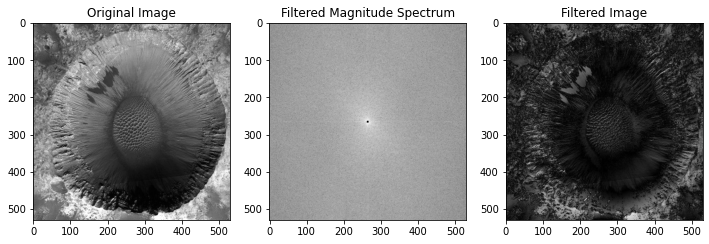

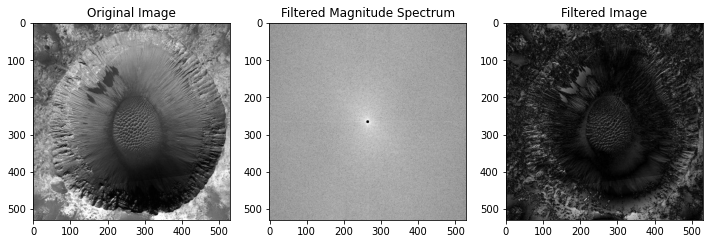

In [13]:
outer_radius = 1000

center_radii = [i*1 for i in range(5)]

# Read the image from the URL
url = 'https://pbs.twimg.com/media/Eb7ZCe4XkAEJPTz?format=jpg&name=small'
resp = urllib.request.urlopen(url)
img = np.asarray(bytearray(resp.read()), dtype="uint8")
img = cv2.imdecode(img, cv2.IMREAD_GRAYSCALE)

# Calculate the 2D Fourier transform
f = np.fft.fft2(img)

# Shift the zero-frequency component to the center of the spectrum
fshift = np.fft.fftshift(f)


for center_radius in center_radii:
    ### Apply the bandpass filter to the Fourier transform
    fshift_filtered = ftc.apply_bandpass_filter(fshift, center_radius, outer_radius)

    ### Shift the zero-frequency component back to the top-left corner of the spectrum
    f_ishift = np.fft.ifftshift(fshift_filtered)

    ### Calculate the inverse Fourier transform
    img_filtered = np.fft.ifft2(f_ishift)
    img_filtered = np.abs(img_filtered)

    ### Plot the original image and the filtered magnitude spectrum
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
    ax1.imshow(img, cmap='gray')
    ax1.set_title('Original Image')
    ax2.imshow(20*np.log1p(np.abs(fshift_filtered)), cmap='gray')
    ax2.set_title('Filtered Magnitude Spectrum')
    ax3.imshow(img_filtered, cmap='gray')
    ax3.set_title('Filtered Image')
    plt.show()

We see that regions where drastic color changes occur show up as white, and more gradient changes show up as black. This means that 2D FFTs can be used for edge detection! This is useful for many applications in image processing, especially in A.I. training and research. You may wonder what happens if we block out the high frequency terms while keeping the lower ones.

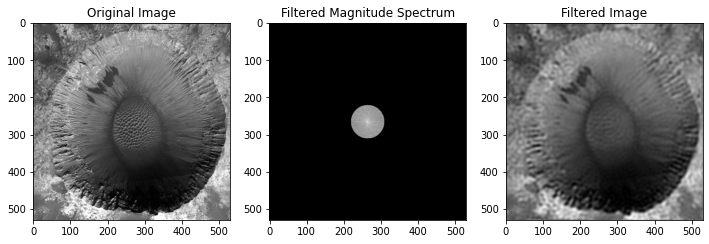

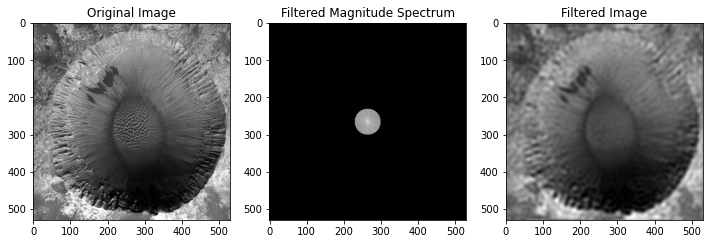

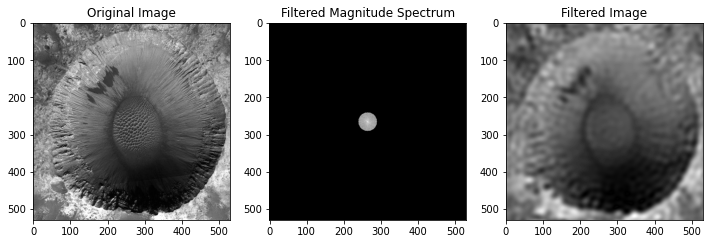

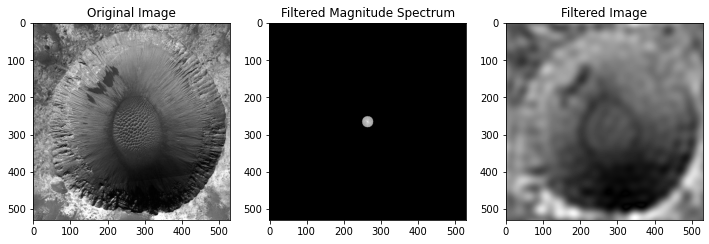

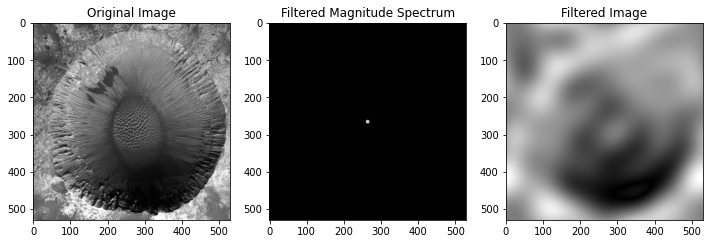

In [14]:
center_radius = 0

outer_radii = [45-i*10 for i in range(5)]

# Read the image from the URL
url = 'https://pbs.twimg.com/media/Eb7ZCe4XkAEJPTz?format=jpg&name=small'
resp = urllib.request.urlopen(url)
img = np.asarray(bytearray(resp.read()), dtype="uint8")
img = cv2.imdecode(img, cv2.IMREAD_GRAYSCALE)

# Calculate the 2D Fourier transform
f = np.fft.fft2(img)

# Shift the zero-frequency component to the center of the spectrum
fshift = np.fft.fftshift(f)


for outer_radius in outer_radii:
    ### Apply the bandpass filter to the Fourier transform
    fshift_filtered = ftc.apply_bandpass_filter(fshift, center_radius, outer_radius)

    ### Shift the zero-frequency component back to the top-left corner of the spectrum
    f_ishift = np.fft.ifftshift(fshift_filtered)

    ### Calculate the inverse Fourier transform
    img_filtered = np.fft.ifft2(f_ishift)
    img_filtered = np.abs(img_filtered)

    ### Plot the original image and the filtered magnitude spectrum
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
    ax1.imshow(img, cmap='gray')
    ax1.set_title('Original Image')
    ax2.imshow(20*np.log1p(np.abs(fshift_filtered)), cmap='gray')
    ax2.set_title('Filtered Magnitude Spectrum')
    ax3.imshow(img_filtered, cmap='gray')
    ax3.set_title('Filtered Image')
    plt.show()

The filtered image becomes blurry! This makes sense, since we are removing any information about sharp changes in the image, so we are left with a smoothed gradient of colors. Messing with different bandpass filters can result in wildly different results. If you use any photo editing software, filters and effects 